<a href="https://colab.research.google.com/github/Palaeoprot/IPA/blob/main/Polymer_IPA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation Model for Peptide Decay and Racemization

## Overview

This simulation model is designed to study the decay and racemization of a peptide polymer over time. The model uses a simple model with only three amino acids A, P, and I and tracks the breakdown of peptide bonds, the formation of free amino acids, and the racemization (conversion between L and D forms) of these amino acids. Multiple simulations are run to average the results, providing smoother and more reliable data.

## The Players I P A

- **I and i - Internal Racemization**: Simulates Asx [and Ser and Glx?] - is able to undergo racemization in chain
- **P and p - Polar Residue**: Simulates Tyr, Thr, Ser, Cys,  More accessible to water for hydrolysis.
- **A and a Apolar residues**: Simules Val, Phe, Ile, Leu  [and Ala] residues that are harder to racemize
- **Special cases**: Serie decays to racemiice alanaine.  Gln and Glu from a stable lactam and are not observed as free amino acids. These special cases have not been implemented yet.

## Key Features

- **Peptide Decay**: Simulates the hydrolysis of peptide bonds in the polymer, resulting in smaller fragments over time.
- **Racemization**: Simulates the racemization of amino acids, converting between L and D forms at different rates for free and bound amino acids.
- **Multiple Simulations**: Runs multiple simulations with the same initial polymer to average the results and reduce random fluctuations.
- **Threshold for D/L Ratio Detection**: Applies a threshold to avoid choppy output when the numbers of free amino acids are very low.

## Model Components

### Constants and Parameters

- **LEN**: Length of the initial polymer.
- **H**: Base hydrolysis rate.
- **HYDL_SCALE_RATE**: Factor to scale the hydrolysis rates for different bond types.
- **R, R_FAST, R_FREE**: Racemization rates for in-chain, fast racemizing amino acids, and free amino acids respectively.
- **BOND_RATES**: Dictionary containing the hydrolysis rates for different types of peptide bonds.
- **L_AMINO_ACIDS, D_AMINO_ACIDS**: Lists of L and D forms of the amino acids.
- **DL_THRESHOLD_PERCENTAGE**: Minimum percentage of free amino acids required to detect and plot the D/L ratio.

### Functions

- **create_polymer(length)**: Generates an initial polymer sequence of given length using random L amino acids.
- **racemize(aa, is_free)**: Simulates racemization of an amino acid, considering whether it is free or part of a chain.
- **decay_step(fragment)**: Simulates a single step of peptide bond hydrolysis, creating new fragments.
- **count_amino_acids(sequence)**: Counts the number of each type of amino acid in a sequence.
- **simulate_decay_and_racemization(initial_polymer, time_steps)**: Runs the decay and racemization simulation for a single polymer over a specified number of time steps.
- **average_simulations(simulations)**: Averages the results from multiple simulations to produce smoother data.
- **calculate_dl_ratio(counts, aa)**: Calculates the D/L ratio for a given amino acid type, considering a threshold for detection.

### Simulation Process

1. **Initialization**: Create an initial polymer sequence of length `LEN`.
2. **Multiple Simulations**: Run `num_simulations` simulations with the same initial polymer to average the results.
3. **Decay and Racemization**: For each time step, simulate bond hydrolysis and racemization, and track the resulting fragments and free amino acids.
4. **Data Collection**: Collect data on average peptide lengths, free amino acid counts, and total amino acid counts over time.
5. **D/L Ratio Calculation**: Calculate D/L ratios for total and free amino acids, applying a threshold for free amino acids to avoid low-number artifacts.
6. **Plotting and Analysis**: Plot the results to visualize the decay process, the formation of free amino acids, and the racemization dynamics.

### Plotting Results

- **Average Peptide Size**: Plots the average size of peptide fragments over time on a logarithmic scale.
- **Percentage of FAA Amino Acids**: Plots the percentage of free amino acids relative to the initial counts for each amino acid type.
- **D/L Ratio (THAA System)**: Plots the D/L ratio for each amino acid type in the total system over time.
- **D/L Ratio (FAA Amino Acids)**: Plots the D/L ratio for free amino acids, applying a threshold to ensure reliable detection.

### Final Statistics

The final statistics provide a summary of the total amino acid composition and D/L ratios for both the total system and the free amino acids at the end of the simulation.

### Output

Files are saved to .csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from scipy.optimize import curve_fit

In [ ]:
#@title #Define Constant

# Polymer properties (fixed)
N = 10000  # Initial number of units
f_I = 0.2  # Fraction of I residues
f_P = 0.4  # Fraction of P residues
f_A = 0.4  # Fraction of A residues
water_conc = 1.0  # Water concentration (fixed)

# Simplified model parameters
k_hydrolysis = 0.00002  # Base hydrolysis rate
k_hydrolysis_I_factor = 14 # Magnitude increase in I hydrolysis rate - used in function 'hydrolysis_model'
k_rac_internal_I = 0.003  # Racemisation rate for I in the chain
k_rac_terminal = 0.0004  # Unified racemisation rate for I, P, and A at the end terminus
k_rac_free = 0.00005  # Racemisation rate for free amino acids
k_loss_I = 0.001  # Loss of total amino acids
k_loss_A = 0.0005  # Loss of total amino acids
k_loss_P = 0.0004  # Loss of total amino acids


# Color settings
colors = {
    'Asx': '#ff7f0e',
    'Glx': '#2ca02c',
    'Val': '#d62728',
    'I': '#ff7f0e',
    'P': '#2ca02c',
    'A': '#d62728',
    'Blanks': '#7d7d7d'  # Grey color for blanks
}

## Read and clean the data from the CSV file
This should have the following headings:


> Condition (e.g. site, age, treatement), Fraction (FAA, THAA), time (h)

>[Asx], [Glx],[Ser],[L-Thr],[L-His],[Gly],[L-Arg],[Ala],[Tyr],[Val],[Phe],[Leu],[Ile],TOTAL

>  Asx D/L,Glx D/L,Ser D/L,Arg D/L,Ala D/L,Tyr D/L,Val D/L,Phe D/L,Leu D/L,Ile D/L


In [ ]:
file_path = '/content/drive/MyDrive/Colab_Notebooks/AAR_Model/OES.csv'
df = pd.read_csv(file_path)

# Ensure "time (h)" column is read as numeric
df['time (h)'] = pd.to_numeric(df['time (h)'], errors='coerce')

# Filter data for the "Neutral" condition
#df_neutral = df[df['Condition'] == 'Neutral']
df_neutral = df[(df['pH'] == 7) & (df['temp (°C)'] == 110)]

# Create a dummy blank row if no blanks are present
if 'BLANK' not in df['Fraction'].unique():
    df_blanks = pd.DataFrame({'time (h)': [0], '[Asx]': [0], '[Glx]': [0], '[Val]': [0], 'Asx D/L': [0], 'Glx D/L': [0], 'Val D/L': [0]})
else:
    df_blanks = df[df['Fraction'] == 'BLANK']  # Filter blanks for plotting

# Simulation duration based on the maximum value in the time (h) column
#simulation_hours = df['time (h)'].max()  # Maximum time for the simulation in hours
timesteps = 100
simulation_hours = 1500

# Clean the data by removing rows with NaN or infinite values in 'time (h)' or 'Asx D/L'
df_neutral = df_neutral.replace([np.inf, -np.inf], np.nan).dropna(subset=['time (h)', 'Asx D/L', '[Asx]', '[Glx]', '[Val]'])
df_blanks = df_blanks.replace([np.inf, -np.inf], np.nan).dropna(subset=['time (h)', 'Asx D/L', '[Asx]', '[Glx]', '[Val]'])

# Separate FAA and THAA fractions
df_free = df_neutral[df_neutral['Fraction'] == 'FAA']
df_total = df_neutral[df_neutral['Fraction'] == 'THAA']

# Add an additional point at time 0 with total concentration of 1
df_total = pd.concat([pd.DataFrame({'time (h)': [0], '[Asx]': [1], '[Glx]': [1], '[Val]': [1], 'Asx D/L': [0], 'Glx D/L': [0], 'Val D/L': [0]}), df_total], ignore_index=True)

# Add a corresponding row to df_free with zeros at time 0
df_free = pd.concat([pd.DataFrame({'time (h)': [0], '[Asx]': [0], '[Glx]': [0], '[Val]': [0], 'Asx D/L': [0], 'Glx D/L': [0], 'Val D/L': [0]}), df_free], ignore_index=True)

In [ ]:
#@title ##Define functions
# Define functions
def pseudo_first_order_rate(f_residue, k_residue, water_conc):
    """
    Calculates the pseudo first-order rate constant.
    """
    return k_residue * water_conc * f_residue

def hydrolysis_model(t, f_tot, k_hydrolysis, initial_conc, k_loss):
    global k_hydrolysis_I_factor
    k_I = k_hydrolysis_I_factor * k_hydrolysis  # I is 10 times faster
    k_P = k_hydrolysis       # P is the base rate
    k_A = k_hydrolysis       # A is the same as P

    k_eff_I = pseudo_first_order_rate(f_tot * f_I, k_I, water_conc)
    k_eff_P = pseudo_first_order_rate(f_tot * f_P, k_P, water_conc)
    k_eff_A = pseudo_first_order_rate(f_tot * f_A, k_A, water_conc)

    hydrolysis_I = initial_conc * (1 - np.exp(-k_eff_I * t)) * np.exp(-k_loss * t)
    hydrolysis_P = initial_conc * (1 - np.exp(-k_eff_P * t)) * np.exp(-k_loss * t)
    hydrolysis_A = initial_conc * (1 - np.exp(-k_eff_A * t)) * np.exp(-k_loss * t)

    return hydrolysis_I, hydrolysis_P, hydrolysis_A

# Define the racemisation model function
def racemisation_model(t, k_internal, k_terminal, k_free):
    """
    Simulate the racemisation of the amino acids.
    """
    # Avoid overflow and underflow in exponential calculations
    internal_ratio = (1 - np.exp(-2 * k_internal * t)) / (1 + np.exp(-2 * k_internal * t))
    internal_ratio = np.nan_to_num(internal_ratio, nan=0.0, posinf=1.0, neginf=-1.0)

    terminal_ratio = (1 - np.exp(-2 * k_terminal * t)) / (1 + np.exp(-2 * k_terminal * t))
    terminal_ratio = np.nan_to_num(terminal_ratio, nan=0.0, posinf=1.0, neginf=-1.0)

    free_ratio = (1 - np.exp(-2 * k_free * t)) / (1 + np.exp(-2 * k_free * t))
    free_ratio = np.nan_to_num(free_ratio, nan=0.0, posinf=1.0, neginf=-1.0)

    return internal_ratio, terminal_ratio, free_ratio

def simulate(timesteps, simulation_duration, k_hydrolysis, k_rac_internal_I, k_rac_terminal, k_rac_free, k_loss):
    time = np.linspace(0, simulation_duration, timesteps)

    # Total fraction of hydrolyzable residues
    f_tot = f_I + f_P + f_A

    # Simulate hydrolysis and loss for each residue type
    hydrolysis_levels_I, hydrolysis_levels_P, hydrolysis_levels_A = hydrolysis_model(time, f_tot, k_hydrolysis, 1.0, k_loss)

    # Simulate racemisation
    DL_I_chain, DL_terminal, DL_free = racemisation_model(time, k_rac_internal_I, k_rac_terminal, k_rac_free)

    return time, hydrolysis_levels_I, hydrolysis_levels_P, hydrolysis_levels_A, DL_I_chain, DL_terminal, DL_free

def plot_total_amino_acids(time, total_levels, label, color):
    plt.plot(time, total_levels * 100, label=label, color=color)
    plt.xlabel('Time')
    plt.ylabel('Total Amino Acid Concentration (%)')
    plt.legend()

def fit_k_loss(time, total_conc):
    initial_guess = [0.01]
    params_opt, _ = curve_fit(lambda t, k_loss: np.exp(-k_loss * t), time, total_conc, p0=initial_guess)
    return params_opt[0]

def fit_k_hydrolysis(time, free_conc, f_tot, initial_conc, k_loss):
    initial_guess = [0.001]
    params_opt, _ = curve_fit(lambda t, k_hydrolysis: hydrolysis_model(t, f_tot, k_hydrolysis, initial_conc, k_loss)[0], time, free_conc, p0=initial_guess)
    return params_opt[0]

def plot_bound_amino_acids(time, bound_levels, label, color):
    plt.plot(time, bound_levels * 100, label=label, color=color)
    plt.xlabel('Time')
    plt.ylabel('Bound Amino Acid Concentration (%)')
    plt.legend()

# Optimization Explanation

The optimization process uses the `scipy.optimize.curve_fit` function, which performs a non-linear least squares fitting.
This method adjusts the model parameters to minimize the difference between the observed data and the model prediction.

If the optimization fails, it is usually due to one of the following reasons:
- Poor initial guess: The starting parameters are too far from the optimal values.
- Overfitting: Too many parameters relative to the number of data points.
- Model inadequacy: The model structure is not appropriate for the data.
""")


In [ ]:
def predict_racemization(params, time, k_hydrolysis, k_loss):
    k_rac_internal_I, k_rac_terminal, k_rac_free = params

    # Simulate the levels based on the racemization parameters
    _, hydrolysis_levels_I, hydrolysis_levels_P, hydrolysis_levels_A, DL_I_chain, DL_terminal, DL_free = simulate(len(time), max(time), k_hydrolysis, k_rac_internal_I, k_rac_terminal, k_rac_free, k_loss)

    return np.concatenate((DL_I_chain, DL_terminal, DL_free))


def fitting_racemization_function(time, k_rac_internal_I, k_rac_terminal, k_rac_free):
    return predict_racemization([k_rac_internal_I, k_rac_terminal, k_rac_free], time, k_hydrolysis, k_loss)


# Initial guess for racemization parameters based on simplified model parameters
initial_guess_racemization = [k_rac_internal_I, k_rac_terminal, k_rac_free]


# Define bounds for the parameters to avoid numerical issues
param_bounds = ([1e-6, 1e-6, 1e-6], [1.0, 1.0, 1.0])

# Prepare the observed data for fitting (concatenate the DL ratios)
observed_DL_ratios_total = np.concatenate((df_total['Asx D/L'], df_total['Glx D/L'], df_total['Val D/L']))
observed_DL_ratios_free = np.concatenate((df_free['Asx D/L'], df_free['Glx D/L'], df_free['Val D/L']))

# Combine total and free observed data
observed_DL_ratios_combined = np.concatenate((observed_DL_ratios_total, observed_DL_ratios_free))

# Combine time data
time_combined = np.concatenate((df_total['time (h)'], df_free['time (h)']))

# Fit the racemization model to the observed data with bounds
print("Initial guess for racemization parameters:")
param_names_racemization = ["k_rac_internal_I", "k_rac_terminal", "k_rac_free"]
for name, value in zip(param_names_racemization, initial_guess_racemization):
    print(f"{name}: {value}")

# Fixed parameters
fixed_params = {
    'N': N,
    'f_I': f_I,
    'f_P': f_P,
    'f_A': f_A,
    'water_conc': water_conc,
    'timesteps': timesteps,
    'simulation_hours': simulation_hours,
    'k_hydrolysis': k_hydrolysis
}

print("\nFixed parameters used in the model:")
for name, value in fixed_params.items():
    print(f"{name}: {value}")

params_opt_racemization, params_cov_racemization = curve_fit(
    fitting_racemization_function,
    time_combined,
    observed_DL_ratios_combined,
    p0=initial_guess_racemization,
    bounds=param_bounds
)

print("\nFitted racemization parameters:")
for name, value in zip(param_names_racemization, params_opt_racemization):
    print(f"{name}: {value}")


def plot_bound_amino_acids(time, bound_levels, label, color):
    plt.plot(time, bound_levels * 100, label=label, color=color)
    plt.xlabel('Time')
    plt.ylabel('Bound Amino Acid Concentration (%)')
    plt.legend()

Initial guess for racemization parameters:
k_rac_internal_I: 0.003
k_rac_terminal: 0.0004
k_rac_free: 5e-05

Fixed parameters used in the model:
N: 10000
f_I: 0.2
f_P: 0.4
f_A: 0.4
water_conc: 1.0
timesteps: 100
simulation_hours: 1500
k_hydrolysis: 2e-05

Fitted racemization parameters:
k_rac_internal_I: 0.0007691414009174908
k_rac_terminal: 0.0008277978468091724
k_rac_free: 0.0006859149072132511


In [2]:
#@title ###Use original model parameters
# Define your own values for racemization rates
k_rac_internal_I_custom = 0.0045  # Custom racemization rate for I in the chain
k_rac_terminal_custom = 0.0006   # Custom unified racemization rate for I, P, and A at the end terminus
k_rac_free_custom = 0.000005       # Custom racemization rate for free amino acids
k_hydrolysis_custom = 0.0003       # Custom rate of hydrolysis
k_hydrolysis_I_factor = 10  # Custom rate of hydrolysis magnitude for I
k_loss_custom_I = 0.0006 # Custom rate of loss
k_loss_custom_A = 0.0006 # Custom rate of loss
k_loss_custom_P = 0.0006 # Custom rate of loss

In [ ]:
# Example fitting for Val
time_total = df_total['time (h)']
val_total_conc = df_total['[Val]']  # Normalized to 1
k_loss_val = fit_k_loss(time_total, val_total_conc)
print("Fitted k_loss for Val:", k_loss_val)

val_free_conc = df_free['[Val]']  # Normalized to 1
k_hydrolysis_val = fit_k_hydrolysis(time_total, val_free_conc, f_I + f_P + f_A, 1, k_loss_val)
print("Fitted k_hydrolysis for Val:", k_hydrolysis_val)

In [1]:
#Glx special code
# Manually input k_loss and k_hydrolysis for Glx if needed
k_loss_glx = 0.01  # Example value
k_hydrolysis_glx = 0.001  # Example value

# Fit k_hydrolysis for Glx if not manually set
if not k_hydrolysis_glx:
    glx_free_conc = df_free['[Glx]']  # Normalized to 1
    k_hydrolysis_glx = fit_k_hydrolysis(time_total, glx_free_conc, f_I + f_P + f_A, 1, k_loss_glx)
    print("Fitted k_hydrolysis for Glx:", k_hydrolysis_glx)

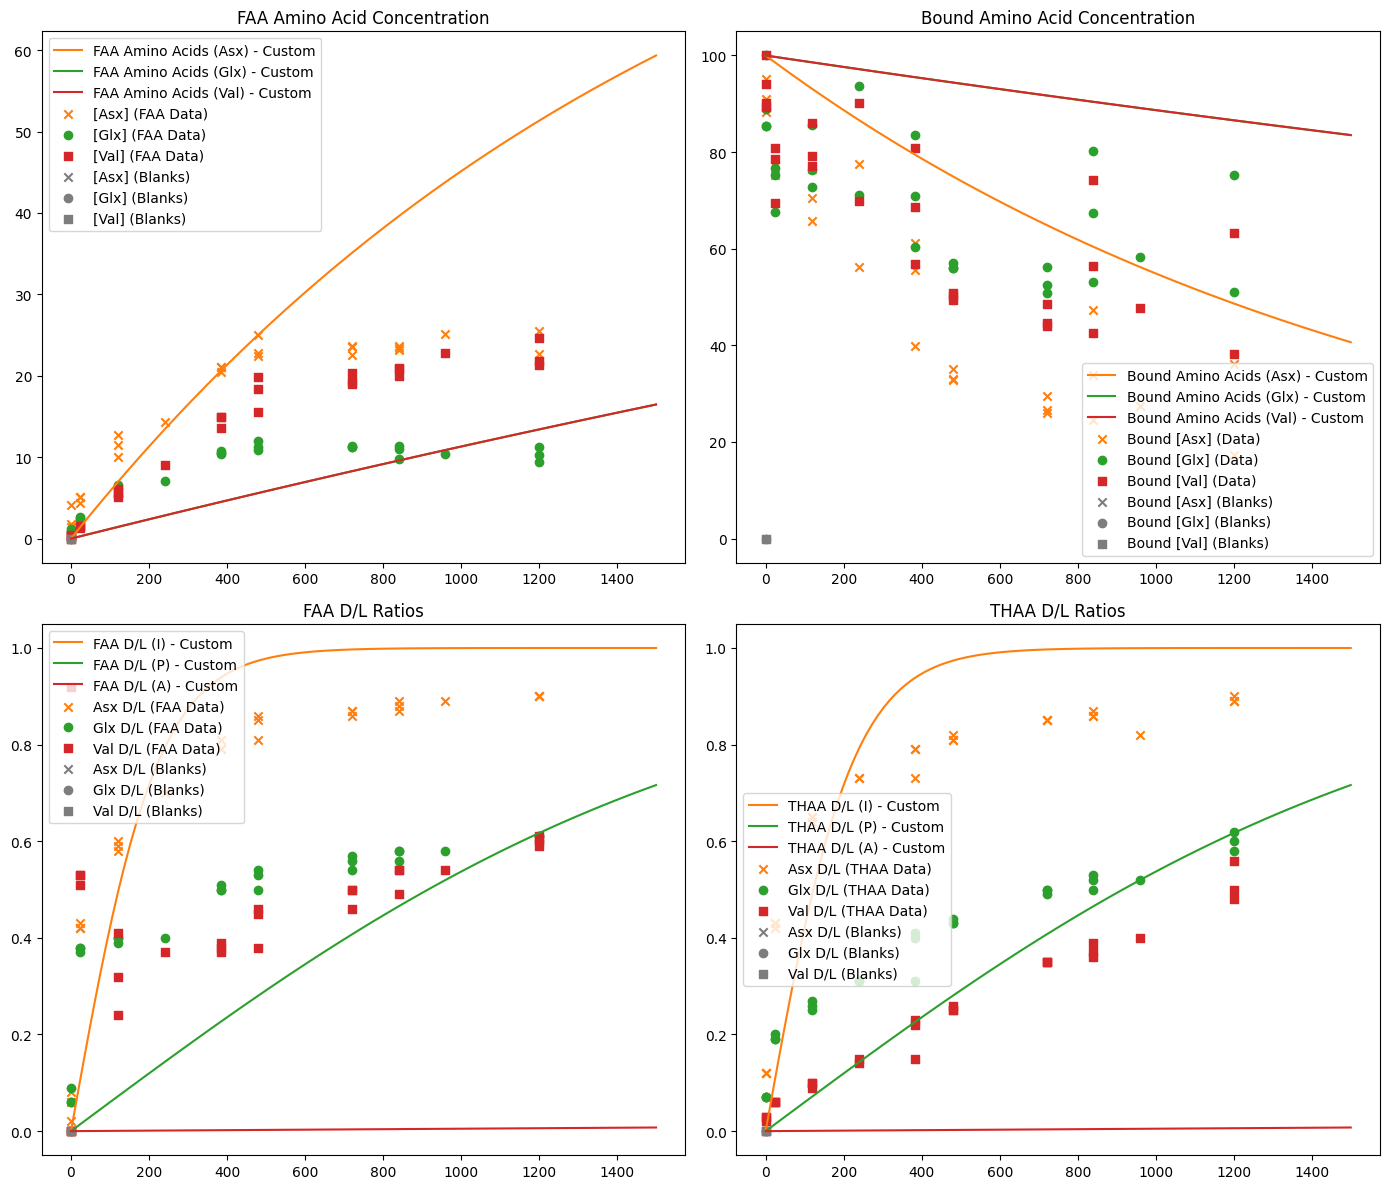

In [ ]:
#@title ###Run the simulation with your own values
# Run the simulation with your own values
time_custom, hydrolysis_levels_I_custom, hydrolysis_levels_P_custom, hydrolysis_levels_A_custom, DL_I_chain_custom, DL_terminal_custom, DL_free_custom = simulate(
    timesteps, simulation_hours,
    k_hydrolysis_custom,
    k_rac_internal_I_custom,
    k_rac_terminal_custom,
    k_rac_free_custom
    k_loss_custom
)


# Plotting the results of your custom simulation
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Plot FAA Amino Acid Concentration
axs[0, 0].plot(time_custom, hydrolysis_levels_I_custom * 100, label='FAA Amino Acids (Asx) - Custom', color=colors['Asx'])
axs[0, 0].plot(time_custom, hydrolysis_levels_P_custom * 100, label='FAA Amino Acids (Glx) - Custom', color=colors['Glx'])
axs[0, 0].plot(time_custom, hydrolysis_levels_A_custom * 100, label='FAA Amino Acids (Val) - Custom', color=colors['Val'])
axs[0, 0].scatter(df_free['time (h)'], df_free['[Asx]'] * 100, color=colors['Asx'], label='[Asx] (FAA Data)', marker='x')
axs[0, 0].scatter(df_free['time (h)'], df_free['[Glx]'] * 100, color=colors['Glx'], label='[Glx] (FAA Data)', marker='o')
axs[0, 0].scatter(df_free['time (h)'], df_free['[Val]'] * 100, color=colors['Val'], label='[Val] (FAA Data)', marker='s')
if len(df_blanks) > 0:
    axs[0, 0].scatter(df_blanks['time (h)'], df_blanks['[Asx]'] * 100, color=colors['Blanks'], label='[Asx] (Blanks)', marker='x')
    axs[0, 0].scatter(df_blanks['time (h)'], df_blanks['[Glx]'] * 100, color=colors['Blanks'], label='[Glx] (Blanks)', marker='o')
    axs[0, 0].scatter(df_blanks['time (h)'], df_blanks['[Val]'] * 100, color=colors['Blanks'], label='[Val] (Blanks)', marker='s')
axs[0, 0].set_title('FAA Amino Acid Concentration')
axs[0, 0].legend()

# # Plot Bound Amino Acid Concentration (THAA - FAA)
# axs[0, 1].plot(time_custom, (np.ones_like(time_custom) - hydrolysis_levels_I_custom) * 100, label='Bound Amino Acids (Asx) - Custom', color=colors['Asx'])
# axs[0, 1].plot(time_custom, (np.ones_like(time_custom) - hydrolysis_levels_P_custom) * 100, label='Bound Amino Acids (Glx) - Custom', color=colors['Glx'])
# axs[0, 1].plot(time_custom, (np.ones_like(time_custom) - hydrolysis_levels_A_custom) * 100, label='Bound Amino Acids (Val) - Custom', color=colors['Val'])
# axs[0, 1].scatter(df_total['time (h)'], (df_total['[Asx]'] - df_free['[Asx]']) * 100, color=colors['Asx'], label='Bound [Asx] (Data)', marker='x')
# axs[0, 1].scatter(df_total['time (h)'], (df_total['[Glx]'] - df_free['[Glx]']) * 100, color=colors['Glx'], label='Bound [Glx] (Data)', marker='o')
# axs[0, 1].scatter(df_total['time (h)'], (df_total['[Val]'] - df_free['[Val]']) * 100, color=colors['Val'], label='Bound [Val] (Data)', marker='s')
# if len(df_blanks) > 0:
#     axs[0, 1].scatter([0], [df_blanks.iloc[0]['[Asx]'] * 100], color=colors['Blanks'], label='Bound [Asx] (Blanks)', marker='x')
#     axs[0, 1].scatter([0], [df_blanks.iloc[0]['[Glx]'] * 100], color=colors['Blanks'], label='Bound [Glx] (Blanks)', marker='o')
#     axs[0, 1].scatter([0], [df_blanks.iloc[0]['[Val]'] * 100], color=colors['Blanks'], label='Bound [Val] (Blanks)', marker='s')
# axs[0, 1].set_title('Bound Amino Acid Concentration')
# axs[0, 1].legend()

# Plot FAA D/L ratios
axs[1, 0].plot(time_custom, DL_I_chain_custom, label='FAA D/L (I) - Custom', color=colors['I'])
axs[1, 0].plot(time_custom, DL_terminal_custom, label='FAA D/L (P) - Custom', color=colors['P'])
axs[1, 0].plot(time_custom, DL_free_custom, label='FAA D/L (A) - Custom', color=colors['A'])
axs[1, 0].scatter(df_free['time (h)'], df_free['Asx D/L'], color=colors['Asx'], label='Asx D/L (FAA Data)', marker='x')
axs[1, 0].scatter(df_free['time (h)'], df_free['Glx D/L'], color=colors['Glx'], label='Glx D/L (FAA Data)', marker='o')
axs[1, 0].scatter(df_free['time (h)'], df_free['Val D/L'], color=colors['Val'], label='Val D/L (FAA Data)', marker='s')
if len(df_blanks) > 0:
    axs[1, 0].scatter(df_blanks['time (h)'], df_blanks['Asx D/L'], color=colors['Blanks'], label='Asx D/L (Blanks)', marker='x')
    axs[1, 0].scatter(df_blanks['time (h)'], df_blanks['Glx D/L'], color=colors['Blanks'], label='Glx D/L (Blanks)', marker='o')
    axs[1, 0].scatter(df_blanks['time (h)'], df_blanks['Val D/L'], color=colors['Blanks'], label='Val D/L (Blanks)', marker='s')
axs[1, 0].set_title('FAA D/L Ratios')
axs[1, 0].legend()

# Plot THAA D/L ratios
axs[1, 1].plot(time_custom, DL_I_chain_custom, label='THAA D/L (I) - Custom', color=colors['I'])
axs[1, 1].plot(time_custom, DL_terminal_custom, label='THAA D/L (P) - Custom', color=colors['P'])
axs[1, 1].plot(time_custom, DL_free_custom, label='THAA D/L (A) - Custom', color=colors['A'])
axs[1, 1].scatter(df_total['time (h)'], df_total['Asx D/L'], color=colors['Asx'], label='Asx D/L (THAA Data)', marker='x')
axs[1, 1].scatter(df_total['time (h)'], df_total['Glx D/L'], color=colors['Glx'], label='Glx D/L (THAA Data)', marker='o')
axs[1, 1].scatter(df_total['time (h)'], df_total['Val D/L'], color=colors['Val'], label='Val D/L (THAA Data)', marker='s')
if len(df_blanks) > 0:
    axs[1, 1].scatter(df_blanks['time (h)'], df_blanks['Asx D/L'], color=colors['Blanks'], label='Asx D/L (Blanks)', marker='x')
    axs[1, 1].scatter(df_blanks['time (h)'], df_blanks['Glx D/L'], color=colors['Blanks'], label='Glx D/L (Blanks)', marker='o')
    axs[1, 1].scatter(df_blanks['time (h)'], df_blanks['Val D/L'], color=colors['Blanks'], label='Val D/L (Blanks)', marker='s')
axs[1, 1].set_title('THAA D/L Ratios')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
#@title ###Simulate with fitted racemization parameters
time, hydrolysis_levels_I, hydrolysis_levels_P, hydrolysis_levels_A, DL_I_chain, DL_terminal, DL_free = simulate(
    timesteps, simulation_hours,
    k_hydrolysis,
    params_opt_racemization[0],  # k_rac_internal_I
    params_opt_racemization[1],  # k_rac_terminal
    params_opt_racemization[2]   # k_rac_free
)

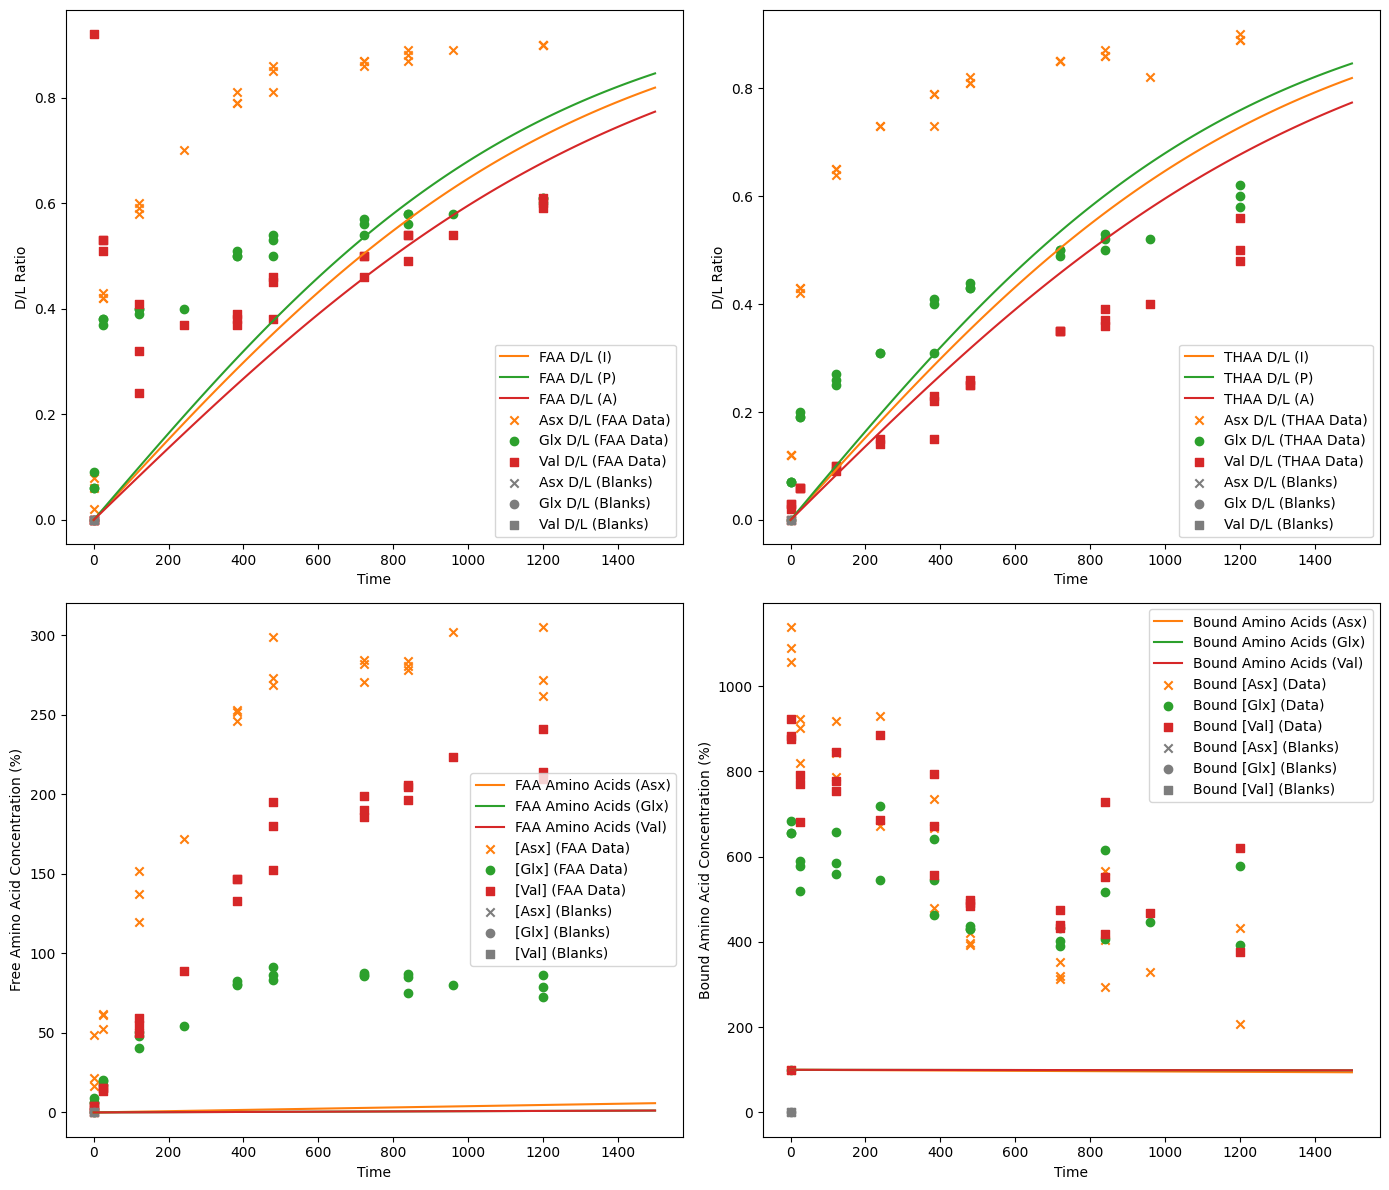

In [ ]:
#@title ###Plotting functions
plt.figure(figsize=(14, 12))

# Plot FAA D/L ratios
plt.subplot(2, 2, 1)
plot_DL_free(time, DL_I_chain, 'FAA D/L (I)', colors['I'])
plot_DL_free(time, DL_terminal, 'FAA D/L (P)', colors['P'])
plot_DL_free(time, DL_free, 'FAA D/L (A)', colors['A'])
plt.scatter(df_free['time (h)'], df_free['Asx D/L'], color=colors['Asx'], label='Asx D/L (FAA Data)', marker='x')
plt.scatter(df_free['time (h)'], df_free['Glx D/L'], color=colors['Glx'], label='Glx D/L (FAA Data)', marker='o')
plt.scatter(df_free['time (h)'], df_free['Val D/L'], color=colors['Val'], label='Val D/L (FAA Data)', marker='s')
plt.scatter(df_blanks['time (h)'], df_blanks['Asx D/L'], color=colors['Blanks'], label='Asx D/L (Blanks)', marker='x')
plt.scatter(df_blanks['time (h)'], df_blanks['Glx D/L'], color=colors['Blanks'], label='Glx D/L (Blanks)', marker='o')
plt.scatter(df_blanks['time (h)'], df_blanks['Val D/L'], color=colors['Blanks'], label='Val D/L (Blanks)', marker='s')
plt.legend()

# Plot THAA D/L ratios
plt.subplot(2, 2, 2)
plot_DL_total(time, DL_I_chain, 'THAA D/L (I)', colors['I'])
plot_DL_total(time, DL_terminal, 'THAA D/L (P)', colors['P'])
plot_DL_total(time, DL_free, 'THAA D/L (A)', colors['A'])
plt.scatter(df_total['time (h)'], df_total['Asx D/L'], color=colors['Asx'], label='Asx D/L (THAA Data)', marker='x')
plt.scatter(df_total['time (h)'], df_total['Glx D/L'], color=colors['Glx'], label='Glx D/L (THAA Data)', marker='o')
plt.scatter(df_total['time (h)'], df_total['Val D/L'], color=colors['Val'], label='Val D/L (THAA Data)', marker='s')
plt.scatter(df_blanks['time (h)'], df_blanks['Asx D/L'], color=colors['Blanks'], label='Asx D/L (Blanks)', marker='x')
plt.scatter(df_blanks['time (h)'], df_blanks['Glx D/L'], color=colors['Blanks'], label='Glx D/L (Blanks)', marker='o')
plt.scatter(df_blanks['time (h)'], df_blanks['Val D/L'], color=colors['Blanks'], label='Val D/L (Blanks)', marker='s')
plt.legend()

# Plot FAA Amino Acid Concentration
plt.subplot(2, 2, 3)
plot_free_amino_acids(time, hydrolysis_levels_I, 'FAA Amino Acids (Asx)', colors['Asx'])
plot_free_amino_acids(time, hydrolysis_levels_P, 'FAA Amino Acids (Glx)', colors['Glx'])
plot_free_amino_acids(time, hydrolysis_levels_A, 'FAA Amino Acids (Val)', colors['Val'])
plt.scatter(df_free['time (h)'], df_free['[Asx]'] * 100, color=colors['Asx'], label='[Asx] (FAA Data)', marker='x')
plt.scatter(df_free['time (h)'], df_free['[Glx]'] * 100, color=colors['Glx'], label='[Glx] (FAA Data)', marker='o')
plt.scatter(df_free['time (h)'], df_free['[Val]'] * 100, color=colors['Val'], label='[Val] (FAA Data)', marker='s')
plt.scatter(df_blanks['time (h)'], df_blanks['[Asx]'] * 100, color=colors['Blanks'], label='[Asx] (Blanks)', marker='x')
plt.scatter(df_blanks['time (h)'], df_blanks['[Glx]'] * 100, color=colors['Blanks'], label='[Glx] (Blanks)', marker='o')
plt.scatter(df_blanks['time (h)'], df_blanks['[Val]'] * 100, color=colors['Blanks'], label='[Val] (Blanks)', marker='s')
plt.legend()

# Plot Bound Amino Acid Concentration (THAA - FAA)
plt.subplot(2, 2, 4)
plot_bound_amino_acids(time, np.ones_like(time) - hydrolysis_levels_I, 'Bound Amino Acids (Asx)', colors['Asx'])
plot_bound_amino_acids(time, np.ones_like(time) - hydrolysis_levels_P, 'Bound Amino Acids (Glx)', colors['Glx'])
plot_bound_amino_acids(time, np.ones_like(time) - hydrolysis_levels_A, 'Bound Amino Acids (Val)', colors['Val'])
plt.scatter(df_total['time (h)'], (df_total['[Asx]'] - df_free['[Asx]']) * 100, color=colors['Asx'], label='Bound [Asx] (Data)', marker='x')
plt.scatter(df_total['time (h)'], (df_total['[Glx]'] - df_free['[Glx]']) * 100, color=colors['Glx'], label='Bound [Glx] (Data)', marker='o')
plt.scatter(df_total['time (h)'], (df_total['[Val]'] - df_free['[Val]']) * 100, color=colors['Val'], label='Bound [Val] (Data)', marker='s')
if len(df_blanks) > 0:
    plt.scatter([0], [df_blanks.iloc[0]['[Asx]'] * 100], color=colors['Blanks'], label='Bound [Asx] (Blanks)', marker='x')
    plt.scatter([0], [df_blanks.iloc[0]['[Glx]'] * 100], color=colors['Blanks'], label='Bound [Glx] (Blanks)', marker='o')
    plt.scatter([0], [df_blanks.iloc[0]['[Val]'] * 100], color=colors['Blanks'], label='Bound [Val] (Blanks)', marker='s')
plt.legend()

plt.tight_layout()
plt.show()
